## Tic-Tac-Toe Agent
​
In this notebook, I have implemented an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:

        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries


In [1]:
from TCGame_Env import TicTacToe 
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
#create an instance of the env. The env is a MDP Implementation of Tic Tac Toe Game
env = TicTacToe()

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [6]:
# printing the default tic tac toe board positions
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

In [7]:
#Print the valid actions of agent for the default state
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
    if z > epsilon:
        # ===> Q value fetch max value
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        # ===> random action generation
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [9]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [10]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [('x-3-x-x-x-6-x-x-x',(0,1)),
                       ('x-1-x-x-x-x-8-x-x',(2,9)),
                       ('x-x-x-x-6-x-x-x-5',(2,7)),
                       ('x-x-x-x-9-x-6-x-x',(1,7)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('9-x-5-x-x-x-8-x-4',(1,3)),
                       ('2-7-x-x-6-x-x-3-x',(8,5)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5)),
                       ('5-x-x-x-x-6-x-x-x',(4,9)),
                       ('4-x-x-6-x-x-3-1-x',(8,5)),
                       ('5-x-8-x-x-6-3-x-x',(3,1)),
                       ('x-6-5-x-2-x-x-3-x',(0,7)),
                       ('7-x-5-x-2-x-x-x-6',(1,3))]
    
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []  


In [11]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [12]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

### Define hyperparameters 

In [13]:
#EPISODES = 15000000
#EPISODES = 200000
EPISODES= 5000000
LR = 0.20   # learning rate
GAMMA = 0.91 #discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.000001  #epsilon decay rate

threshold = 50000      #no of episodes after which tracked states will be saved
policy_threshold = 500000 #no of episodes after which Q Dictionary/table will be saved

#logging
checkpoint_print_episodes = 500000

In [14]:
initialise_tracking_states()

### Q-update loop

In [15]:
start_time = time.time()

q_track={}
q_track['x-3-x-x-x-6-x-x-x']=[]
q_track['x-1-x-x-x-x-8-x-x']=[]
q_track['x-x-x-x-6-x-x-x-5']=[]
q_track['x-x-x-x-9-x-6-x-x']=[]
q_track['x-5-x-2-x-x-4-7-x']=[]
q_track['9-x-5-x-x-x-8-x-4']=[]
q_track['2-7-x-x-6-x-x-3-x']=[]
q_track['9-x-x-x-x-2-x-x-x']=[]
q_track['x-x-7-x-x-x-x-x-2']=[]
q_track['5-x-x-x-x-6-x-x-x']=[]
q_track['4-x-x-6-x-x-3-1-x']=[]
q_track['5-x-8-x-x-6-3-x-x']=[]
q_track['x-6-5-x-2-x-x-3-x']=[]
q_track['7-x-5-x-2-x-x-x-6']=[] 

#for tracking wins
agent_won_count = 0
env_won_count = 0
tie_count = 0

for episode in tqdm(range(EPISODES)):
    
    env = TicTacToe()  #initialize env for the episode
    
    #initialize variables
    curr_state = env.state
    is_terminal = False
    add_to_dict(curr_state)  #add current state to the dictionary
    total_reward = 0 
    
 
    while not (is_terminal):
        curr_lookup = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode) #Find action using the epsilon method
        
        if Q_state(curr_state) in q_track.keys():
            q_track[Q_state(curr_state)].append(curr_action)
            
        next_state, reward, is_terminal, msg = env.step(curr_state, curr_action) #Use the env and push the action, to obtain reward
        
      
        next_lookup = Q_state(next_state)
        
        #Updating rules/Q values
        if is_terminal:
            
            # Tracking the count of games won by agent and environment
            if msg == "Agent Won!":
                agent_won_count += 1
            elif msg == "Environment Won!":
                env_won_count += 1
            else:
                tie_count += 1
            Q_dict[curr_lookup][curr_action] += LR *(reward - Q_dict[curr_lookup][curr_action])
        else:
            #Update the rewards
            add_to_dict(next_state)
            max_next = max(Q_dict[next_lookup], key = Q_dict[next_lookup].get)
            Q_dict[curr_lookup][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_lookup][max_next])))
                                                            - Q_dict[curr_lookup][curr_action])
   
    
    #transition to the next state       
    curr_state = next_state
    total_reward += reward
    
    # Tracking the Q-Values here
    if (episode + 1) % checkpoint_print_episodes == 0:
        print("After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie : %.4f"% (episode + 1, 
            agent_won_count / (episode + 1), env_won_count /(episode + 1), tie_count / (episode + 1)))

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
    
    if ((episode + 1) % 1000000) == 0:
        print('Processed %dM episodes'%((episode+1)/1000000))

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print('Total Execution time: ',elapsed_time)    
    


 10%|▉         | 499946/5000000 [07:37<1:03:08, 1187.88it/s]

After playing 500000 games, Agent Won : 0.3798, Environment Won : 0.3407, Tie : 0.2796


 20%|█▉        | 999886/5000000 [14:00<45:43, 1458.07it/s]  

After playing 1000000 games, Agent Won : 0.4858, Environment Won : 0.2795, Tie : 0.2347
Processed 1M episodes


 30%|██▉       | 1499989/5000000 [19:28<35:52, 1625.69it/s]  

After playing 1500000 games, Agent Won : 0.5775, Environment Won : 0.2297, Tie : 0.1928


 40%|███▉      | 1999927/5000000 [24:31<28:32, 1752.20it/s] 

After playing 2000000 games, Agent Won : 0.6460, Environment Won : 0.1922, Tie : 0.1618
Processed 2M episodes


 50%|████▉     | 2499827/5000000 [29:23<23:10, 1798.22it/s] 

After playing 2500000 games, Agent Won : 0.6985, Environment Won : 0.1633, Tie : 0.1382


 60%|█████▉    | 2999855/5000000 [33:51<16:54, 1972.37it/s] 

After playing 3000000 games, Agent Won : 0.7395, Environment Won : 0.1409, Tie : 0.1197
Processed 3M episodes


 70%|██████▉   | 3499957/5000000 [38:11<12:28, 2003.36it/s] 

After playing 3500000 games, Agent Won : 0.7718, Environment Won : 0.1232, Tie : 0.1050


 80%|███████▉  | 3999981/5000000 [42:18<08:25, 1976.44it/s] 

After playing 4000000 games, Agent Won : 0.7976, Environment Won : 0.1091, Tie : 0.0933
Processed 4M episodes


 90%|████████▉ | 4499858/5000000 [46:27<03:47, 2200.53it/s] 

After playing 4500000 games, Agent Won : 0.8185, Environment Won : 0.0977, Tie : 0.0838


100%|█████████▉| 4999799/5000000 [50:32<00:00, 2061.15it/s]

After playing 5000000 games, Agent Won : 0.8357, Environment Won : 0.0883, Tie : 0.0760
Processed 5M episodes


100%|██████████| 5000000/5000000 [50:35<00:00, 1647.39it/s]


Total Execution time:  3035.127825021744


#### Check the Q-dictionary

In [16]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 6.14956553626771,
              (0, 3): 5.808261629622652,
              (0, 5): 5.809681781552876,
              (0, 7): 4.443467151426164,
              (0, 9): 1.2403526036653274,
              (1, 1): 6.223967037630841,
              (1, 3): 6.004382196437686,
              (1, 5): 5.937705291355084,
              (1, 7): -0.32303190709718066,
              (1, 9): 3.9606947734499136,
              (2, 1): 6.23759018012,
              (2, 3): 5.894794672794001,
              (2, 5): 5.171802430112432,
              (2, 7): 4.275416442152891,
              (2, 9): 0.7273794121222754,
              (3, 1): 6.00531041552991,
              (3, 3): 6.045763913968391,
              (3, 5): 6.215862650033614,
              (3, 7): 4.4885169593065175,
              (3, 9): 0.37064953453105076,
              (4, 1): 7.504339329984063,
              (4, 3): 5.409965594754116,
              (4, 5): 4.679127921062582,
              (

In [17]:
len(Q_dict)

982405

In [18]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
Q_dict['x-x-x-x-x-8-x-x-3']


{(0, 1): -0.9363509501588144,
 (0, 5): 1.1097084312416423,
 (0, 7): -0.95601953488896,
 (0, 9): -3.5261352638648154,
 (1, 1): -1.3522540247449601,
 (1, 5): 0.9846722839985332,
 (1, 7): -0.95601953488896,
 (1, 9): -1.3284232897868773,
 (2, 1): 1.6248640501977851,
 (2, 5): 0.07058528251446561,
 (2, 7): -0.9718525023289344,
 (2, 9): -1.1508032149419196,
 (3, 1): -3.1644850175999997,
 (3, 5): -1.3502605055557628,
 (3, 7): 9.999999999999996,
 (3, 9): -0.919054782464,
 (4, 1): -1.75382784,
 (4, 5): 0.4987066540395857,
 (4, 7): 9.718525023289343,
 (4, 9): -2.34993573576704,
 (6, 1): -0.8375790324420219,
 (6, 5): -1.8647598116864004,
 (6, 7): -0.8093623229229128,
 (6, 9): -1.605183899025408,
 (7, 1): -2.0584675875743312,
 (7, 5): 0.33036990241833003,
 (7, 7): -0.47468392361531764,
 (7, 9): -1.1462130562616526}

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [19]:
# Write the code for plotting the graphs for state-action pairs tracked
States_track.keys()
States_track['x-3-x-x-x-6-x-x-x']

{(0, 1): [-0.488,
  -0.5904,
  -0.5904,
  -0.5904,
  -0.5904,
  -0.446656,
  -0.5573248,
  -0.5573248,
  -0.4546802380799999,
  0.32441580953600035,
  0.32441580953600035,
  0.32441580953600035,
  0.32441580953600035,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.059532647628800284,
  0.21162611810304024,
  0.21162611810304024,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  -0.030699105517567826,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.663600715585946,
  0.6636007155

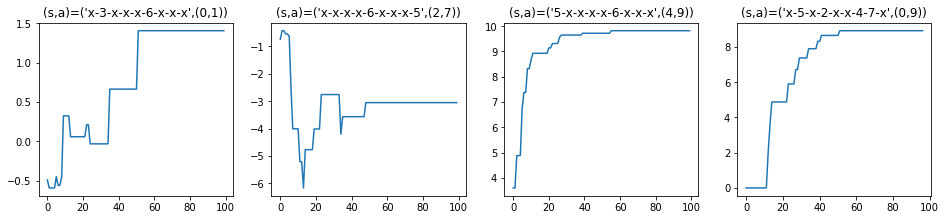

In [20]:
plt.figure(0, figsize=(16,7))
plt.subplot(241)
t1=States_track['x-3-x-x-x-6-x-x-x'][(0,1)]
plt.title("(s,a)=('x-3-x-x-x-6-x-x-x',(0,1))")
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))

plt.subplot(242)
t2=States_track['x-x-x-x-6-x-x-x-5'][(2,7)]
plt.title("(s,a)=('x-x-x-x-6-x-x-x-5',(2,7))")
plt.plot(np.asarray(range(0, len(t2))),np.asarray(t2))

plt.subplot(243)
t3=States_track['5-x-x-x-x-6-x-x-x'][(4,9)]
plt.title("(s,a)=('5-x-x-x-x-6-x-x-x',(4,9))")
plt.plot(np.asarray(range(0, len(t3))),np.asarray(t3))

plt.subplot(244)
t4=States_track['x-5-x-2-x-x-4-7-x'][(0,9)]
plt.title("(s,a)=('x-5-x-2-x-x-4-7-x',(0,9))")
plt.plot(np.asarray(range(0, len(t4))),np.asarray(t4))

plt.show()


**Observation** - Looks like the loss values have converged after 5million iterations. We have a winner

### Ref : Epsilon - decay check

In [21]:
#Used above to find the right value of the decay and used in the learning function
def generate_epsilon(time):
    max_epsilon = 1.0
    min_epsilon = 0.001
    time = np.arange(0,time)
    epsilon = []
    for i in time:
        epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))
    return (time,epsilon)
        
time, epsilon = generate_epsilon(5000000)

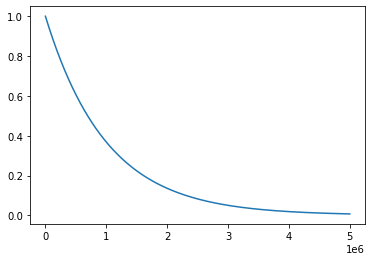

In [22]:
plt.plot(time, epsilon)
plt.show()